# **Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"**

Nhóm 3:
1. 1712401 - Hồ Trường Giang - TruongGiangBT
2. 1712575 - Hoàng Xuân Long - dralong10
3. 18120249 - Hồ Minh Trí - Crys-Zz0o0
4. 18120374 - Nguyễn Minh Hiếu - templarassVN

Link thùng chứa Github của nhóm: [Link](https://github.com/templarassVN/Team-3_KHDLUD_K18)

## Mô tả bài toán

- Là cuộc thi dự đoán đội thắng và đội thua trong giải đấu bóng rổ nam NCAA năm 2021 (2020-2021) (2021 NCAA Division I Men's Basketball Tournament). [Link](https://www.kaggle.com/c/ncaam-march-mania-2021)
- Cuộc thi chia làm 2 giai đoạn:
  - Giai đoạn 1: Ban tổ chức sẽ cung cấp dữ liệu các trận đấu của các đội ở các mùa giải trước đến mùa giải 2019. Mục đích là để người tham gia có dữ liệu để xây dựng và thử nghiệm các mô hình.
  - Giai đoạn 2: Ban tổ chức sẽ cung cấp thêm dữ liệu về các đội được tham gia giải đấu năm 2021. Người tham gia sẽ tiến hành dự đoán và submit kết quả.
- Tổng quan về giải đấu:
  - Giải đấu gồm 68 đội tham gia chia đều ở 4 khu vực.
  - 8 đội First-Four sẽ thi đấu 4 trận đấu đầu tiên để tranh quyền đi tiếp => Còn lại 64 đội (Mỗi khu cực có 16 đội).
  - 16 đội trong mỗi khu vực sẽ đấu loại trực tiếp theo quy định của giải đấu và chọn ra đội thắng cuộc đại diện cho khu vực thi đấu ở vòng Final Four. Tại vòng Final Four, 4 đội đại diện cho 4 khu vực tiếp tục loại trực tiếp nhau và chọn ra người thắng chung cuộc. 
  - Tổng cộng sẽ có 67 trận đấu (gồm 4 trận First-Four, 15 trận đấu loại khu vực * 4 khu vực, 3 trận Final Four).
- Mô hình bài toán: Dựa vào các thông số thi đấu và thành tích. Ta sẽ thực hiện huấn luyện mô hình với input đầu vào là ID 2 đội (TeamIdA,TeamIdB) và các thuộc tính được rút trích của mỗi đội. Nhãn của mỗi cặp đấu có giá trị là 0 hoặc 1 (0 - đội A thua; 1 - đội A thắng)
- Input bài toán: Đầu vào bài toán là danh sách 68 đội tham gia giải đấu, về mặt lý thuyết ta sẽ có 68*67/2 = 2278 cặp đấu khác nhau. Ta sẽ dự đoán kết quả của 2278 cặp đấu.
- Output: Xác suất đội A thắng đội B.
- Cấu trúc file Submission gồm:
  - Id: [Mùa giải]_ [TeamIdA]_[TeamIdB]. Ex: 2021_1101_1102
  - Pred: Xác suất đội A thắng đội B
- Đánh giá kết quả: Kết quả dự đoán được đánh giá bằng hàm Log Loss.
$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$

## Giải quyết bài toán

- Nhóm đã tìm hiểu và cài đặt lại [giải pháp của tác giả kazukim](https://www.kaggle.com/c/ncaam-march-mania-2021/discussion/230946), đứng thứ 4 private leaderboard với score là 0.56346.
- Nhóm chọn giải này vì đây là giải pháp giành thứ hạng cao trong cuộc thi, tác giả có đề ra những đặc trưng hiệu quả trong việc dự đoán kết quả.

### I. Nạp dữ liệu và thư viện cần thiết

In [ ]:
!gdown --id 1c6Iiy39qeiI1sH1N5MKrBe1C9e8E16Hl
!gdown --id 1Bwe5QinxXItR6g5ODd8AGFYeHQR1xNJ-
!unzip ncaam-march-mania-2021.zip

In [1]:
# Load các thư viện cần thiết
!pip install lightgbm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

### II. Đọc dữ liệu

- Giải pháp hiện tại nhóm đang làm sử dụng dữ liệu từ 4 file csv: 
  - MMasseyOrdinals.csv
    - Mô tả: Là danh sách thứ hạng của các đội kể từ mùa giải 2003 dựa trên các hệ thống xếp hạng.
    - Thuộc tính:
      - Season: năm của mùa giải.
      - RatingDayNum: ngày trong mùa giải đó (Ngày bắt đầu mùa giải => RatingDayNum = 0).
      - SystemName: tên hệ thống xếp hạng, gồm 3 chữ cái in hoa.
      - TeamID: mã số của đội, gồm số có 4 chữ số, bắt đầu từ 1101.
      - OrdinalRank: thứ hạng.
  - MNCAATourneySeeds.csv
    - Mô tả: Xác định hạt giống của các đội tham gia giải đấu ở các mùa giải.
    - Thuộc tính:
      - Season, Team ID.
      - Seed: chuỗi gồm 3 hoặc 4 kí tự, kí tự đầu tiên ứng với mã khu vực của đội, 2 kí tự số tiếp theo là hạng hạt giống của đội, kí tự thứ 4 (nếu có) để phân biệt đội sẽ tham gia First-Four (Ví dụ: W11a - đội này xếp hạng hạt giống 11 trong khu vực W về sẽ thi đấu First-Four).
  - MRegularSeasonDetailedResults.csv
    - Mô tả: Cung cấp kết quả chi tiết của các trận đấu trước giải đấu (DayNum < 132), bao gồm điểm số và thông số trận đấu của các cặp đấu.
    - Thuộc tính:
      - Season
      - WTeamID, LTeamID: ID của đội thắng/đội thua.
      - DayNum: ngày thi đấu.
      - WScore, LScore: số điểm ghi được của đội thắng/ đội thua.
      - WLoc: đội được chơi trên sân: H - sân nhà, A - sân khách, N - sân trung lập.
      - NumOT: thời gian bù giờ.
      - WFGM, WFGA, WFGM3, WFGA3, WFTM, WFTA, WOR, WDR, WAst, WTO, WStl, WBlk, WPF: các thông số trận đấu của đội thắng. Tương tự, đội thua có kí tự 'L' ở đầu. 
  - MNCAATourneyCompactResults.csv
    - Mô tả: Cung cấp kết quả rút gọn của các trận đấu trong mùa giải, gồm điểm số của các cặp đấu.
    - Thuộc tính:
      - Season, WTeamID, LTeamID, DayNum, WScore, LScore, WLoc, NumOT

In [2]:
datasets_path = './MDataFiles_Stage2/'
os.listdir('./MDataFiles_Stage2/')

['MRegularSeasonCompactResults.csv',
 'MNCAATourneyCompactResults.csv',
 'MNCAATourneySeeds.csv',
 'MTeamSpellings.csv',
 'MTeams.csv',
 'MRegularSeasonDetailedResults.csv',
 'MGameCities.csv',
 'MSecondaryTourneyTeams.csv',
 'MSampleSubmissionStage2.csv',
 'MNCAATourneySeedRoundSlots.csv',
 'MSecondaryTourneyCompactResults.csv',
 'MTeamCoaches.csv',
 'MNCAATourneySlots.csv',
 'MConferenceTourneyGames.csv',
 'MSeasons.csv',
 'Conferences.csv',
 'MMasseyOrdinals.csv',
 'MTeamConferences.csv',
 'Cities.csv',
 'MNCAATourneyDetailedResults.csv']

In [3]:
ordinals = pd.read_csv(datasets_path + 'MMasseyOrdinals.csv').rename(columns={'RatingDayNum':'DayNum'})
seeds = pd.read_csv(datasets_path + 'MNCAATourneySeeds.csv')
regular_results = pd.read_csv(datasets_path + 'MRegularSeasonDetailedResults.csv')
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')

### III. Prerocessing, Feature Extraction

#### 1. Tính trung bình tất cả hệ thống Rank, chuyển đồi sang Rating
- Dựa vào bảng MMasseyOrdinals, tính thứ hạng trung bình ở các hệ thống Ranking của các đội. Tạo ra thêm thuộc tính Rating để đánh giá các đội dựa vào thứ hạng của họ

In [4]:
ordinals = pd.read_csv(datasets_path + 'MMasseyOrdinals.csv').rename(columns={'RatingDayNum':'DayNum'})
ordinals

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260
...,...,...,...,...,...
4339985,2021,133,WOB,1467,233
4339986,2021,133,WOB,1468,176
4339987,2021,133,WOB,1469,290
4339988,2021,133,WOB,1470,256


In [5]:
#TO DO: 
# Xác định miền giá trị của OrdinalRank
ordinals.describe()

,Season,RankingDayNum,TeamID,OrdinalRank
count,4.339990e+06,4.339990e+06,4.339990e+06,4.339990e+06
mean,2.013435e+03,8.627139e+01,1.284589e+03,1.720421e+02
std,5.059901e+00,3.251639e+01,1.044671e+02,1.005553e+02
min,2.003000e+03,0.000000e+00,1.101000e+03,1.000000e+00
25%,2.010000e+03,6.300000e+01,1.194000e+03,8.500000e+01
50%,2.014000e+03,9.100000e+01,1.283000e+03,1.720000e+02
75%,2.018000e+03,1.140000e+02,1.376000e+03,2.590000e+02
max,2.021000e+03,1.330000e+02,1.471000e+03,3.570000e+02


In [6]:
#Lấy thứ hạn cuối cùng (thường DayNum=133) theo nhóm
ordinals = ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()
# Tạo bảng gồm Season, TeamID, OrdinalRank; với OrdinalRank là thứ hạn trung bình trên các SystemName
ordinals = ordinals.groupby(['Season','TeamID'])['OrdinalRank'].apply(list).apply(np.mean).reset_index()
# Thêm thuộc tính Rating
ordinals['Rating'] = 100 - 4*np.log(ordinals['OrdinalRank'])
ordinals

,Season,TeamID,OrdinalRank,Rating
0,2003,1102,154.058824,79.850662
1,2003,1103,168.705882,79.487373
2,2003,1104,36.638889,85.595559
3,2003,1105,308.735294,77.070063
4,2003,1106,260.911765,77.743271
...,...,...,...,...
6539,2021,1467,240.490566,78.069277
6540,2021,1468,180.288462,79.221767
6541,2021,1469,314.666667,76.993944
6542,2021,1470,252.823529,77.869233


Text(0.5, 1.0, 'Rating')

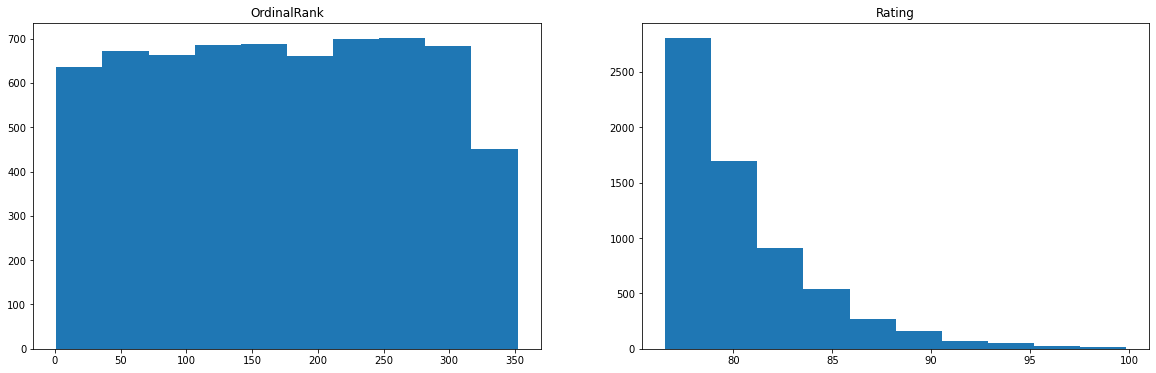

In [7]:
f = plt.figure(figsize=(20,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(ordinals["OrdinalRank"])
ax1.set_title("OrdinalRank")
ax2.hist(ordinals["Rating"])
ax2.set_title("Rating")

Explain:

Trước đó ta thấy: Miền giá trị của OrdinalRank (thứ hạng) nằm trong [1-351]. Nhằm tránh mô hình phức tạp thì tác giả đã dùng hàm để biến đổi các biến:

$$\textrm{Y} = 100 - 4 \times log({X}) $$

[1-351] -> [100 - 89], mong muốn của tác giả là thứ hạng càng cao thì Rating càng cao.

Ngoài ra, rõ ràng có sự khác biệt giữa các thứ hạng từ thấp tới cao.


#### 2. Tính số trận thắng/thua của đội trong mùa giải
- Dựa vào bảng MRegularSeasonDetailedResults, tính số trận thắng / trận thua của các đội trong mùa giải

In [10]:
regular_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96682,2021,132,1104,80,1261,79,N,0,33,76,...,27,9,13,15,26,10,5,6,5,13
96683,2021,132,1159,85,1259,72,H,0,31,59,...,22,9,16,12,19,12,12,2,1,13
96684,2021,132,1222,91,1153,54,N,0,37,66,...,33,10,15,14,17,11,10,2,5,12
96685,2021,132,1228,91,1326,88,N,1,29,64,...,25,22,30,8,27,11,8,7,4,26


In [11]:
# Đếm số tận thắng
num_win = regular_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
# Đếm số trận thua
num_lose = regular_results.groupby(['Season', 'LTeamID']).count()
num_lose = num_lose.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLoses", "LTeamID": "TeamID"})
# Ghép 2 bảng lại
win_lose = pd.merge(num_win, num_lose, how='outer', on=['Season', 'TeamID']).fillna(0).sort_values(by=['Season','TeamID']).reset_index(drop=True)
win_lose

,Season,TeamID,NumWins,NumLoses
0,2003,1102,12.0,16.0
1,2003,1103,13.0,14.0
2,2003,1104,17.0,11.0
3,2003,1105,7.0,19.0
4,2003,1106,13.0,15.0
...,...,...,...,...
6529,2021,1467,9.0,9.0
6530,2021,1468,11.0,7.0
6531,2021,1469,6.0,13.0
6532,2021,1470,5.0,10.0


Text(0.5, 1.0, 'NumLoses')

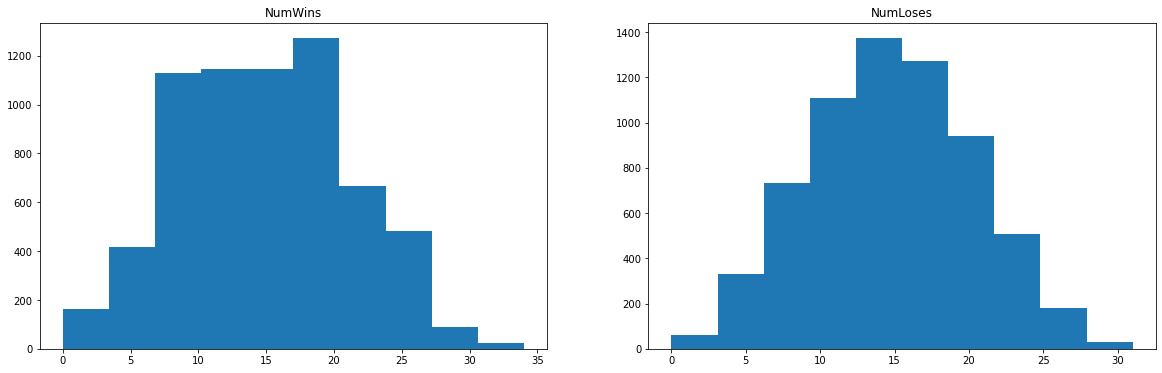

In [20]:
f = plt.figure(figsize=(20,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(win_lose["NumWins"])
ax1.set_title("NumWins")
ax2.hist(win_lose["NumLoses"])
ax2.set_title("NumLoses")

#### 3. Thống kê trung bình số liệu của đội trong mỗi mùa giải
- Dựa vào bảng MRegularSeasonDetailedResults, thống kê số liệu trận đấu trung bình của đội trong mùa giải.

In [26]:
# Tính trung bình số liệu trận thắng của mỗi đội theo mùa
wteam_stats = regular_results.groupby(['Season', 'WTeamID']).mean().reset_index()
# Loại bỏ các thuộc tính của đội thua
wteam_stats = wteam_stats.drop(['DayNum','LTeamID', 'NumOT','LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 
                                'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',], axis=1)
# Đổi tên các thuộc tính của đội thắng thành tên chung
wteam_stats = wteam_stats.rename(columns={"WTeamID": "TeamID", 'WScore':'Score','LScore':'Scored', 'WFGM':'FGM',
                                        'WFGA':'FGA', 'WFGM3':'FGM3','WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA',
                                        'WOR':'OR', 'WDR':'DR','WAst':'Ast','WTO':'TO','WStl':'Stl','WBlk':'Blk','WPF':'PF'})
wteam_stats

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,68.750000,53.166667,22.583333,40.000000,10.000000,21.583333,13.583333,20.750000,3.833333,19.333333,16.916667,11.083333,7.333333,2.833333,16.083333
1,2003,1103,87.769231,78.384615,30.000000,55.384615,5.461538,14.384615,22.307692,30.923077,9.384615,21.461538,17.692308,12.538462,7.307692,1.846154,20.461538
2,2003,1104,74.705882,61.529412,25.823529,58.352941,7.058824,20.823529,16.000000,22.529412,13.529412,26.411765,14.000000,13.058824,7.235294,4.176471,16.470588
3,2003,1105,79.428571,66.428571,25.571429,61.857143,9.142857,22.428571,19.142857,25.714286,14.571429,25.857143,15.857143,18.000000,11.285714,2.000000,19.428571
4,2003,1106,68.307692,57.923077,24.769231,53.846154,5.846154,15.923077,12.923077,20.769231,12.769231,28.000000,13.000000,17.692308,9.384615,3.769231,18.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,2021,1467,71.000000,61.777778,25.888889,53.000000,7.111111,21.777778,12.111111,17.888889,5.777778,25.000000,13.444444,13.888889,8.222222,3.888889,3.555556
6524,2021,1468,76.000000,62.363636,28.363636,55.181818,6.636364,18.454545,12.636364,16.181818,7.545455,21.636364,15.909091,10.636364,7.181818,2.272727,1.636364
6525,2021,1469,76.666667,71.833333,25.833333,59.166667,6.833333,19.833333,18.166667,23.500000,7.500000,23.833333,15.000000,12.666667,7.333333,1.666667,3.333333
6526,2021,1470,69.000000,56.200000,24.000000,50.800000,5.800000,12.800000,15.200000,18.400000,3.800000,22.800000,14.400000,8.000000,6.200000,2.000000,15.000000


In [27]:
# Tính trung bình số liệu trận thua của mỗi đội theo mùa
lteam_stats = regular_results.groupby(['Season', 'LTeamID']).mean().reset_index()
# Loại bỏ các thuộc tính của đội thắng
lteam_stats = lteam_stats.drop(['DayNum', 'WTeamID', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM',
                                'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], axis=1)
# Đổi tên các thuộc tính của đội thua thành tên chung
lteam_stats = lteam_stats.rename(columns={"LTeamID": "TeamID", 'LScore':'Score','WScore':'Scored', 'LFGM':'FGM',
                                        'LFGA':'FGA', 'LFGM3':'FGM3','LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA',
                                        'LOR':'OR', 'LDR':'DR','LAst':'Ast','LTO':'TO','LStl':'Stl','LBlk':'Blk','LPF':'PF'})
lteam_stats

,Season,TeamID,Scored,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,59.875000,48.625000,16.562500,39.625000,6.187500,20.250000,9.312500,14.375000,4.437500,14.937500,10.062500,11.687500,4.937500,1.000000,20.750000
1,2003,1103,77.928571,70.428571,24.500000,56.285714,5.428571,17.642857,16.000000,21.142857,10.142857,18.500000,12.928571,12.714286,7.214286,2.785714,19.285714
2,2003,1104,70.363636,60.909091,21.272727,55.363636,5.272727,18.363636,13.090909,18.454545,13.636364,20.090909,9.181818,13.636364,5.636364,3.181818,20.454545
3,2003,1105,80.421053,68.947368,23.947368,61.526316,7.000000,20.157895,14.052632,20.421053,13.105263,22.105263,14.052632,18.894737,8.578947,2.105263,20.526316
4,2003,1106,68.800000,59.533333,22.266667,56.533333,6.333333,19.133333,8.666667,12.733333,11.866667,20.266667,10.533333,16.466667,7.466667,2.600000,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6526,2021,1467,71.555556,61.555556,22.333333,54.444444,6.888889,22.444444,10.000000,15.444444,5.777778,19.222222,10.555556,12.111111,7.777778,3.666667,11.777778
6527,2021,1468,77.571429,67.142857,25.571429,53.428571,5.857143,14.857143,10.142857,14.428571,5.428571,17.000000,14.142857,11.142857,5.714286,1.714286,4.285714
6528,2021,1469,81.153846,63.461538,22.230769,57.230769,5.384615,19.615385,13.615385,19.076923,7.769231,22.846154,14.153846,16.461538,6.461538,2.230769,4.769231
6529,2021,1470,74.100000,61.300000,21.000000,50.900000,5.300000,15.500000,14.000000,19.900000,4.700000,18.800000,9.800000,12.400000,7.000000,2.400000,2.600000


In [29]:
# Ghép 2 số liệu của các trận thắng và thua lại
regular_season_feature = pd.concat([wteam_stats, lteam_stats], 0).reset_index(drop=True)
# Tính trung bình
regular_season_feature = regular_season_feature.groupby(['Season', 'TeamID']).mean().reset_index()
regular_season_feature

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,58.687500,56.520833,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,4.135417,17.135417,13.489583,11.385417,6.135417,1.916667,18.416667
1,2003,1103,79.098901,78.156593,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,9.763736,19.980769,15.310440,12.626374,7.260989,2.315934,19.873626
2,2003,1104,67.807487,65.946524,23.548128,56.858289,6.165775,19.593583,14.545455,20.491979,13.582888,23.251337,11.590909,13.347594,6.435829,3.679144,18.462567
3,2003,1105,74.187970,73.424812,24.759398,61.691729,8.071429,21.293233,16.597744,23.067669,13.838346,23.981203,14.954887,18.447368,9.932331,2.052632,19.977444
4,2003,1106,63.920513,63.361538,23.517949,55.189744,6.089744,17.528205,10.794872,16.751282,12.317949,24.133333,11.766667,17.079487,8.425641,3.184615,18.192308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2021,1467,66.277778,66.666667,24.111111,53.722222,7.000000,22.111111,11.055556,16.666667,5.777778,22.111111,12.000000,13.000000,8.000000,3.777778,7.666667
6530,2021,1468,71.571429,69.967532,26.967532,54.305195,6.246753,16.655844,11.389610,15.305195,6.487013,19.318182,15.025974,10.889610,6.448052,1.993506,2.961039
6531,2021,1469,70.064103,76.493590,24.032051,58.198718,6.108974,19.724359,15.891026,21.288462,7.634615,23.339744,14.576923,14.564103,6.897436,1.948718,4.051282
6532,2021,1470,65.150000,65.150000,22.500000,50.850000,5.550000,14.150000,14.600000,19.150000,4.250000,20.800000,12.100000,10.200000,6.600000,2.200000,8.800000


In [30]:
regular_season_feature.describe().round(2)

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
count,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00,6534.00
mean,2012.12,1284.57,69.53,69.65,24.40,55.95,6.65,19.32,14.08,20.22,10.80,23.74,13.02,13.60,6.48,3.31,17.95
std,5.45,104.61,5.01,4.89,1.94,3.67,1.39,3.56,2.04,2.82,1.96,1.87,1.65,1.78,1.24,1.07,3.51
min,2003.00,1101.00,49.68,52.32,16.88,39.81,2.23,6.78,7.20,11.12,3.42,14.50,7.47,7.23,2.60,0.70,0.00
25%,2007.00,1194.00,66.20,66.39,23.09,53.53,5.66,16.79,12.67,18.32,9.56,22.49,11.91,12.40,5.60,2.54,17.19
50%,2012.00,1283.00,69.50,69.49,24.38,55.95,6.58,19.12,14.05,20.20,10.86,23.72,12.94,13.48,6.40,3.20,18.50
75%,2017.00,1376.00,72.76,72.80,25.69,58.30,7.56,21.57,15.43,22.10,12.10,24.97,14.10,14.73,7.26,3.94,19.76
max,2021.00,1471.00,96.46,95.74,34.15,78.50,12.91,40.16,23.03,35.15,18.31,30.78,19.88,22.43,13.78,9.09,27.48


EXPLAIN:

Vì sao lại chọn mấy thuộc tính này

Theo  [Wiki](https://en.wikipedia.org/wiki/Basketball_statistics) và [Basketball Statistics Definitions](https://www.breakthroughbasketball.com/stats/definitions.html) thì người ta sử dụng các tham số này để đánh giá một cầu thủ (hoặc khả năng của một đội)
* FGM	FGA: (Feild Goal Made | Attempt)
* FGM3 FGA3	: (3 point) [Image](https://www.wikihow.com/images/thumb/3/3b/Shoot-a-Three-Pointer-Step-1-Version-7.jpg/v4-460px-Shoot-a-Three-Pointer-Step-1-Version-7.jpg.webp)
* FTM	FTA: (Free Throw) [Image](https://media.istockphoto.com/vectors/man-shooting-a-basketball-into-a-hoop-and-scoring-from-free-throw-vector-id1303771934?k=20&m=1303771934&s=612x612&w=0&h=R7sT2iTMIMZ_DSiKVl99l1KXj3BUZP6LpXf_JiE_uho=)
* OR	DR: (Offensive | Defensive) Rebound [Link](https://www.rookieroad.com/basketball/stats/rebounds/)
*	Ast:	(Assist) Hỗ trợ ghi điểm 
* TO: (TurnOver) Phản công thành công khi đối phương mất cơ hội	
* Stl: (Steal) Cướp bóng thành công
* Blk: (Block) Chặn bóng thành công
* PF: (Personal Fouls)

EXPLAIN
#### 4. Tính và thêm các thuộc tính Scoregap, FG%, 3P%, FT%, TR, TS%, eFG%, OR%, TOV%, FreeThrows, POSS, PPP
- Scoregap: Hiệu số điểm của đội
- FG%: Hiệu suất ghi bàn [Link](https://jr.nba.com/field-goal-percentage-fg/)
- 3P%: Hiệu suất cú ném 3 điểm [Link](https://www.basketball-reference.com/about/glossary.html#:~:text=3P%25%20%2D%203%2DPoint%20Field,the%20formula%20is%203P%20%2F%203PA.&text=Block%20percentage%20is%20an%20estimate,he%20was%20on%20the%20floor.)
- FT%: (Free Throws) Hiệu suất cú ném tự do [Link](https://www.basketball-reference.com/about/glossary.html#:~:text=3P%25%20%2D%203%2DPoint%20Field,the%20formula%20is%203P%20%2F%203PA.&text=Block%20percentage%20is%20an%20estimate,he%20was%20on%20the%20floor.)
- TR: (Total Rebound) Tổng số lần bắt bóng bật bảng [Link](https://www.basketball-reference.com/about/glossary.html#:~:text=3P%25%20%2D%203%2DPoint%20Field,the%20formula%20is%203P%20%2F%203PA.&text=Block%20percentage%20is%20an%20estimate,he%20was%20on%20the%20floor.)
- TS%: (True Shooting): Ghi điểm từ cú ném bóng chính xác [Link](https://www.nbastuffer.com/analytics101/true-shooting-percentage/)
$$TS = 0.5* Score /  [FGA + 0.44* FTA]$$
- TOV%: Ước lượng khả năng xảy ra Turnover [Link](https://www.basketball-reference.com/about/glossary.html)
$$ TOV = TO / [FGA + 0.44 * FTA + TO]$$
- eFG% Hiệu quả của các cú ném [Link](https://www.nbastuffer.com/analytics101/effective-field-goal-percentage-efg/)
$$eFG = [FGM + 0.5*(FGM3)]/FGA$$
- POSS (Possessions), PPP (Points Per Possessions): hiệu suất biến cơ hội thành bàn thắng. [Link](https://www.nbastuffer.com/analytics101/points-per-possession-ppp/)
$$PPP=Score/[FGA+0.44*FTA+TO]$$

Four-Factor: Theo Oliver Dean thì 4 yếu tố thành công gồm: eFG% (Effective Field Goal Percentage), OR% (Offensive Rebound), TOV% (Turnovers), FreeThrows

In [31]:
########Có thể tự suy ra
# Score-gap: Độ hiệu số điểm
regular_season_feature['Scoregap'] = regular_season_feature['Score'] - regular_season_feature['Scored']
# FG%: Hiệu suất ghi bàn
regular_season_feature['FG%'] = regular_season_feature['FGM']/regular_season_feature['FGA']
# 3P%: Hiệu suất cú ném 3 điểm
regular_season_feature['3P%'] = regular_season_feature['FGM3']/regular_season_feature['FGA3']
# FT% (Free Throws Percentage): Hiệu suất cú ném tự do
regular_season_feature['FT%'] = regular_season_feature['FTM']/regular_season_feature['FTA']
# EV(expect value) ???
regular_season_feature['EV'] = regular_season_feature['FGM']*regular_season_feature['FG%'] \
                            + regular_season_feature['FGM3']*regular_season_feature['3P%'] \
                            + regular_season_feature['FTM']*regular_season_feature['FT%'] \
# TR (Total Rebounds)
regular_season_feature['TR'] = regular_season_feature['OR'] + regular_season_feature['DR']
# OR% (Offensive Rebound) ???
regular_season_feature['OR%'] = regular_season_feature['OR']/regular_season_feature['FGA']
# FreeThrowsRatios
regular_season_feature['FreeThrows'] = regular_season_feature['FTM']/regular_season_feature['FGA']


#########Cần công thức
# TS% (True Shooting Percentage)
regular_season_feature['TS%'] = regular_season_feature['Score']/(2*(regular_season_feature['FGA'] + 0.44*regular_season_feature['FTA']))

# eFG% (Effective Field Goal Percentage)
regular_season_feature['eFG%'] = (regular_season_feature['FGM'] +0.5*regular_season_feature['FGM3'])/regular_season_feature['FGA']

# TOV% (Turnovers)
regular_season_feature['TOV%'] = regular_season_feature['TO']/(regular_season_feature['FGA'] + 0.44*regular_season_feature['FTA'] +regular_season_feature['TO'])

# PPP/POSS (Possessions)
regular_season_feature['POSS'] = regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] + regular_season_feature['TO']
# PPP (Points Per Possessions)
regular_season_feature['PPP'] = regular_season_feature['Score']/regular_season_feature['POSS']

# Win-Lose
regular_season_feature = regular_season_feature.merge(win_lose, on=['Season', 'TeamID'],how='left').reset_index(drop=True)
regular_season_feature['WinRatio'] = regular_season_feature['NumWins']/(regular_season_feature['NumWins'] + regular_season_feature['NumLoses'])

regular_season_feature

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,...,OR%,FreeThrows,TS%,eFG%,TOV%,POSS,PPP,NumWins,NumLoses,WinRatio
0,2003,1102,58.687500,56.520833,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,...,0.103872,0.287546,0.617243,0.593276,0.193217,58.925417,0.995962,12.0,16.0,0.428571
1,2003,1103,79.098901,78.156593,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,...,0.174867,0.343043,0.587749,0.536804,0.157995,79.916044,0.989775,13.0,14.0,0.481481
2,2003,1104,67.807487,65.946524,23.548128,56.858289,6.165775,19.593583,14.545455,20.491979,...,0.238890,0.255819,0.514670,0.468375,0.168483,79.222353,0.855914,17.0,11.0,0.607143
3,2003,1105,74.187970,73.424812,24.759398,61.691729,8.071429,21.293233,16.597744,23.067669,...,0.224314,0.269043,0.516331,0.466758,0.204315,90.288872,0.821673,7.0,19.0,0.269231
4,2003,1106,63.920513,63.361538,23.517949,55.189744,6.089744,17.528205,10.794872,16.751282,...,0.223193,0.195596,0.510871,0.481300,0.214459,79.639795,0.802620,13.0,15.0,0.464286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2021,1467,66.277778,66.666667,24.111111,53.722222,7.000000,22.111111,11.055556,16.666667,...,0.107549,0.205791,0.542766,0.513961,0.175544,74.055556,0.894974,9.0,9.0,0.500000
6530,2021,1468,71.571429,69.967532,26.967532,54.305195,6.246753,16.655844,11.389610,15.305195,...,0.119455,0.209733,0.586272,0.554107,0.151394,71.929091,0.995028,11.0,7.0,0.611111
6531,2021,1469,70.064103,76.493590,24.032051,58.198718,6.108974,19.724359,15.891026,21.288462,...,0.131182,0.273048,0.518489,0.465415,0.177330,82.129744,0.853090,6.0,13.0,0.315789
6532,2021,1470,65.150000,65.150000,22.500000,50.850000,5.550000,14.150000,14.600000,19.150000,...,0.083579,0.287119,0.549548,0.497050,0.146813,69.476000,0.937734,5.0,10.0,0.333333


#### 5. Ghép các bảng lại
- Nối các thuộc tính vừa tính được lại với nhau

In [32]:
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')
# Lấy thông tin mùa giải 2003 đến nay
tourney_results = tourney_results[tourney_results['Season'] >= 2003].reset_index(drop=True)
# Ghép mã các đội thắng với bảng ở mục 4 theo mùa giải
tourney_results = tourney_results.merge(regular_season_feature, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
# Đổi tên thuộc tính
tourney_results = tourney_results.rename(columns={ 'NumWins': 'NumWinsW', 'NumLoses':'NumLosesW', 'WinRatio': 'WinRatioW',
                                                 'FGM':'FGMW', 'FGA':'FGAW', 'FGM3':'FGM3W','FGA3':'FGA3W', 'FTM':'FTMW','FTA':'FTAW',
                                                 'OR':'ORW','DR':'DRW','Ast':'AstW','TO':'TOW','Stl':'StlW','Blk':'BlkW','PF':'PFW',
                                                 'FG%':'FG%W','3P%':'3P%W','FT%':'FT%W','eFG%':'eFG%W','TOV%':'TOV%W',
                                                 'FreeThrows':'FreeThrowsW', 'POSS':'POSSW','PPP':'PPPW','TS%':'TS%W','EV':'EVW','TR':'TRW','OR%':'OR%W',
                                                 'Score':'ScoreW', 'Scored':'ScoredW','Scoregap':'ScoregapW'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thắng với bảng ở mục 1 theo mùa giải
tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], 
                                        how='left').rename(columns={'Rating':'RatingW'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thua với bảng ở mục 4 theo mùa giải
tourney_results = tourney_results.merge(regular_season_feature, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
# Đổi tên thuộc tính
tourney_results = tourney_results.rename(columns={'NumWins': 'NumWinsL', 'NumLoses':'NumLosesL', 'WinRatio': 'WinRatioL',
                                                'FGM':'FGML', 'FGA':'FGAL', 'FGM3':'FGM3L','FGA3':'FGA3L', 'FTM':'FTML', 'FTA':'FTAL', 'OR':'ORL', 
                                                'DR':'DRL','Ast':'AstL','TO':'TOL','Stl':'StlL','Blk':'BlkL','PF':'PFL',
                                                'FG%':'FG%L','3P%':'3P%L','FT%':'FT%L','eFG%':'eFG%L','TOV%':'TOV%L','FreeThrows':'FreeThrowsL',
                                                'POSS':'POSSL','PPP':'PPPL','TS%':'TS%L','EV':'EVL','TR':'TRL','OR%':'OR%L','Score':'ScoreL',
                                                'Scored':'ScoredL','Scoregap':'ScoregapL'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thua với bảng ở mục 1 theo mùa giải
tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], 
                                        how='left').rename(columns={'Rating':'RatingL'}).drop(columns='TeamID', axis=1)
tourney_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'ScoreW', 'ScoredW', 'FGMW', 'FGAW', 'FGM3W', 'FGA3W', 'FTMW',
       'FTAW', 'ORW', 'DRW', 'AstW', 'TOW', 'StlW', 'BlkW', 'PFW', 'ScoregapW',
       'FG%W', '3P%W', 'FT%W', 'EVW', 'TRW', 'OR%W', 'FreeThrowsW', 'TS%W',
       'eFG%W', 'TOV%W', 'POSSW', 'PPPW', 'NumWinsW', 'NumLosesW', 'WinRatioW',
       'RatingW', 'ScoreL', 'ScoredL', 'FGML', 'FGAL', 'FGM3L', 'FGA3L',
       'FTML', 'FTAL', 'ORL', 'DRL', 'AstL', 'TOL', 'StlL', 'BlkL', 'PFL',
       'ScoregapL', 'FG%L', '3P%L', 'FT%L', 'EVL', 'TRL', 'OR%L',
       'FreeThrowsL', 'TS%L', 'eFG%L', 'TOV%L', 'POSSL', 'PPPL', 'NumWinsL',
       'NumLosesL', 'WinRatioL', 'RatingL'],
      dtype='object')

#### 6. Bảng thống kê cuối cùng
- Chỉnh sửa lại tên các thuộc tính

#### 2. Hàm thiết lập đầu vào

In [33]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "Score1", 
        "LTeamID" : "TeamIdB",
        "LScore": "Score2",
        'FGMW':'FGMA', 
        'FGAW':'FGAA', 
        'FGM3W':'FGM3A',
        'FGA3W':'FGA3A',
        'FTMW':'FTMA', 
        'FTAW':'FTAA', 
        'ORW':'ORA', 
        'DRW':'DRA',
        'AstW':'AstA',
        'TOW':'TOA',
        'StlW':'StlA',
        'BlkW':'BlkA',
        'PFW':'PFA',
        'FG%W':'FG%A',
        '3P%W':'3P%A',
        'FT%W':'FT%A',
        'eFG%W':'eFG%A',
        'TOV%W':'TOV%A',
        'FreeThrowsW':'FreeThrowsA',
        'POSSW':'POSSA',
        'PPPW':'PPPA',
        'TS%W':'TS%A',
        'EVW':'EVA',
        'TRW':'TRA',
        'OR%W':'OR%A',
        'ScoreW':'ScoreA',
        'ScoredW':'ScoredA',
        'ScoregapW':'ScoregapA',
        'NumWinsW': 'NumWinsA', 
        'NumLosesW':'NumLosesA', 
        'WinRatioW':'WinRatioA',
        'RatingW': 'RatingA',
        'FGML':'FGMB',
        'FGAL':'FGAB', 
        'FGM3L':'FGM3B',
        'FGA3L':'FGA3B',
        'FTML':'FTMB', 
        'FTAL':'FTAB', 
        'ORL':'ORB',
        'DRL':'DRB',
        'AstL':'AstB',
        'TOL':'TOB',
        'StlL':'StlB',
        'BlkL':'BlkB',
        'PFL':'PFB',
        'FG%L':'FG%B',
        '3P%L':'3P%B',
        'FT%L':'FT%B',
        'eFG%L':'eFG%B',
        'TOV%L':'TOV%B',
        'FreeThrowsL':'FreeThrowsB',
        'POSSL':'POSSB',
        'PPPL':'PPPB',
        'TS%L':'TS%B',
        'EVL':'EVB',
        'TRL':'TRB',
        'OR%L':'OR%B',
        'ScoreL':'ScoreB',
        'ScoredL':'ScoredB',
        'ScoregapL':'ScoregapB',
        'NumWinsL': 'NumWinsB',
        'NumLosesL':'NumLosesB', 
        'WinRatioL':'WinRatioB',
        'RatingL': 'RatingB',
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "Score2", 
        "LTeamID" : "TeamIdA",
        "LScore": "Score1",
        'FGMW':'FGMB', 
        'FGAW':'FGAB', 
        'FGM3W':'FGM3B',
        'FGA3W':'FGA3B',
        'FTMW':'FTMB', 
        'FTAW':'FTAB', 
        'ORW':'ORB', 
        'DRW':'DRB',
        'AstW':'AstB',
        'TOW':'TOB',
        'StlW':'StlB',
        'BlkW':'BlkB',
        'PFW':'PFB',
        'FG%W':'FG%B',
        '3P%W':'3P%B',
        'FT%W':'FT%B',
        'eFG%W':'eFG%B',
        'TOV%W':'TOV%B',
        'FreeThrowsW':'FreeThrowsB',
        'POSSW':'POSSB',
        'PPPW':'PPPB',
        'TS%W':'TS%B',
        'EVW':'EVB',
        'TRW':'TRB',
        'OR%W':'OR%B',
        'ScoreW':'ScoreB',
        'ScoredW':'ScoredB',
        'ScoregapW':'ScoregapB',
        'NumWinsW': 'NumWinsB', 
        'NumLosesW':'NumLosesB', 
        'WinRatioW':'WinRatioB',
        'RatingW': 'RatingB',
        'FGML':'FGMA',
        'FGAL':'FGAA', 
        'FGM3L':'FGM3A',
        'FGA3L':'FGA3A',
        'FTML':'FTMA', 
        'FTAL':'FTAA', 
        'ORL':'ORA',
        'DRL':'DRA',
        'AstL':'AstA',
        'TOL':'TOA',
        'StlL':'StlA',
        'BlkL':'BlkA',
        'PFL':'PFA',
        'FG%L':'FG%A',
        '3P%L':'3P%A',
        'FT%L':'FT%A',
        'eFG%L':'eFG%A',
        'TOV%L':'TOV%A',
        'FreeThrowsL':'FreeThrowsA',
        'POSSL':'POSSA',
        'PPPL':'PPPA',
        'TS%L':'TS%A',
        'EVL':'EVA',
        'TRL':'TRA',
        'OR%L':'OR%A',
        'ScoreL':'ScoreA',
        'ScoredL':'ScoredA',
        'ScoregapL':'ScoregapA',
        'NumWinsL': 'NumWinsA',
        'NumLosesL':'NumLosesA', 
        'WinRatioL':'WinRatioA',
        'RatingL': 'RatingA',
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [34]:
test = pd.read_csv(datasets_path + "MSampleSubmissionStage2.csv")
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['TeamIdA'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['TeamIdB'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2021_1101_1104,0.5,2021,1101,1104
1,2021_1101_1111,0.5,2021,1101,1111
2,2021_1101_1116,0.5,2021,1101,1116
3,2021_1101_1124,0.5,2021,1101,1124
4,2021_1101_1140,0.5,2021,1101,1140


In [35]:
tourney_results = add_loosing_matches(tourney_results)
tourney_results['ScoreDiff'] = tourney_results['Score1'] - tourney_results['Score2']
tourney_results['WinA'] = (tourney_results['ScoreDiff'] > 0).astype(int)
tourney_results

,Season,DayNum,TeamIdA,Score1,TeamIdB,Score2,WLoc,NumOT,ScoreA,ScoredA,...,eFG%B,TOV%B,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB,ScoreDiff,WinA
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,...,0.494006,0.181236,82.535000,0.868318,18.0,12.0,0.600000,78.102523,8,1
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,...,0.478279,0.181825,78.849789,0.836968,19.0,10.0,0.655172,79.873637,29,1
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,...,0.478428,0.157624,84.865072,0.872912,23.0,6.0,0.793103,87.362553,13,1
3,2003,136,1141,79,1166,73,N,0,73.673913,74.753623,...,0.538211,0.172487,79.066207,0.945029,29.0,4.0,0.878788,87.945493,6,1
4,2003,136,1143,76,1301,74,N,1,73.172619,73.044643,...,0.520093,0.186531,76.618333,0.927034,18.0,12.0,0.600000,84.342776,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1246,71,1120,77,N,1,75.601852,72.712963,...,0.526372,0.160476,81.161511,0.939964,25.0,9.0,0.735294,89.346992,-6,0
1111,2019,146,1181,67,1277,68,N,0,81.389655,75.024138,...,0.552164,0.177015,79.223810,0.966896,28.0,6.0,0.823529,93.460691,-1,0
1112,2019,152,1277,51,1403,61,N,0,76.601190,70.428571,...,0.501902,0.173606,76.728205,0.892010,26.0,6.0,0.812500,90.632777,-10,0
1113,2019,152,1120,62,1438,63,N,0,76.288889,72.062222,...,0.542067,0.134805,70.216552,0.990123,29.0,3.0,0.906250,97.585860,-1,0


### IV. Train

#### Đọc file Submission
- Đọc dữ liệu từ file Submission
- Xử lý chuỗi để lấy ra thuộc tính Season, TeamID

#### Ghép ID của mỗi đội với các thuộc tính có


In [36]:
test = test.merge(regular_season_feature, left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={
                'NumWins': 'NumWinsA', 'NumLoses':'NumLosesA', 'WinRatio': 'WinRatioA',
                'FGM':'FGMA', 'FGA':'FGAA', 'FGM3':'FGM3A','FGA3':'FGA3A', 'FTM':'FTMA', 'FTA':'FTAA', 'OR':'ORA', 
                'DR':'DRA','Ast':'AstA','TO':'TOA','Stl':'StlA','Blk':'BlkA','PF':'PFA',
                'FG%':'FG%A','3P%':'3P%A','FT%':'FT%A','eFG%':'eFG%A','TOV%':'TOV%A','FreeThrows':'FreeThrowsA',
                'POSS':'POSSA','PPP':'PPPA','TS%':'TS%A','EV':'EVA','TR':'TRA','OR%':'OR%A','Score':'ScoreA',
                'Scored':'ScoredA','Scoregap':'ScoregapA'}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], 
                how='left').rename(columns={'Rating':'RatingA'}).drop(columns='TeamID', axis=1)

test = test.merge(regular_season_feature, left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={
                'NumWins': 'NumWinsB', 'NumLoses':'NumLosesB', 'WinRatio': 'WinRatioB',
                'FGM':'FGMB', 'FGA':'FGAB', 'FGM3':'FGM3B','FGA3':'FGA3B', 'FTM':'FTMB', 'FTA':'FTAB', 'OR':'ORB', 
                'DR':'DRB','Ast':'AstB','TO':'TOB','Stl':'StlB','Blk':'BlkB','PF':'PFB',
                'FG%':'FG%B','3P%':'3P%B','FT%':'FT%B','eFG%':'eFG%B','TOV%':'TOV%B','FreeThrows':'FreeThrowsB',
                'POSS':'POSSB','PPP':'PPPB','TS%':'TS%B','EV':'EVB','TR':'TRB','OR%':'OR%B','Score':'ScoreB',
                'Scored':'ScoredB','Scoregap':'ScoregapB'}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], 
                how='left').rename(columns={'Rating':'RatingB'}).drop(columns='TeamID', axis=1)
test.columns

Index(['ID', 'Pred', 'Season', 'TeamIdA', 'TeamIdB', 'ScoreA', 'ScoredA',
       'FGMA', 'FGAA', 'FGM3A', 'FGA3A', 'FTMA', 'FTAA', 'ORA', 'DRA', 'AstA',
       'TOA', 'StlA', 'BlkA', 'PFA', 'ScoregapA', 'FG%A', '3P%A', 'FT%A',
       'EVA', 'TRA', 'OR%A', 'FreeThrowsA', 'TS%A', 'eFG%A', 'TOV%A', 'POSSA',
       'PPPA', 'NumWinsA', 'NumLosesA', 'WinRatioA', 'RatingA', 'ScoreB',
       'ScoredB', 'FGMB', 'FGAB', 'FGM3B', 'FGA3B', 'FTMB', 'FTAB', 'ORB',
       'DRB', 'AstB', 'TOB', 'StlB', 'BlkB', 'PFB', 'ScoregapB', 'FG%B',
       '3P%B', 'FT%B', 'EVB', 'TRB', 'OR%B', 'FreeThrowsB', 'TS%B', 'eFG%B',
       'TOV%B', 'POSSB', 'PPPB', 'NumWinsB', 'NumLosesB', 'WinRatioB',
       'RatingB'],
      dtype='object')

#### Chọn ra các đặt trưng để huấn luyện

In [37]:
# Cấu hình các tham số của Model
SEED = 1010
LGBM_PARAMS = {
    'num_leaves': 300, # Số lá tối đa
    'max_bin':450, #Số bin tối đa
    'objective': 'binary', # Loại mô hình (binary: hồi quy logistic)
    'learning_rate': 0.01, # Tỉ lệ học
    'boosting_type': 'gbdt',  
    'random_state': 1010, # Tạo seed random
    'metric':"binary_logloss",
    'verbosity':-1
}
LGBM_FIT_PARAMS = {
    'num_boost_round': 10000, # Số vòng thực hiện tăng cường
    'early_stopping_rounds': 50, # Số lần mà nếu valid_score ngưng cải thiện thì sẽ dừng sớm 
    'verbose_eval': 100, # In ra đánh giá sau verbose_eval lần
}

#### Các tham số LGBM

In [39]:
features = list(tourney_results.columns)
drop_cols = ['Season', 'DayNum', 'TeamIdA', 'Score1', 'TeamIdB', 'Score2', 'NumOT', 'WLoc', 'ScoreDiff', 'WinA']
features = [i for i in features if i not in drop_cols]
categorical_features = []
target = 'WinA'
features

['ScoreA',
 'ScoredA',
 'FGMA',
 'FGAA',
 'FGM3A',
 'FGA3A',
 'FTMA',
 'FTAA',
 'ORA',
 'DRA',
 'AstA',
 'TOA',
 'StlA',
 'BlkA',
 'PFA',
 'ScoregapA',
 'FG%A',
 '3P%A',
 'FT%A',
 'EVA',
 'TRA',
 'OR%A',
 'FreeThrowsA',
 'TS%A',
 'eFG%A',
 'TOV%A',
 'POSSA',
 'PPPA',
 'NumWinsA',
 'NumLosesA',
 'WinRatioA',
 'RatingA',
 'ScoreB',
 'ScoredB',
 'FGMB',
 'FGAB',
 'FGM3B',
 'FGA3B',
 'FTMB',
 'FTAB',
 'ORB',
 'DRB',
 'AstB',
 'TOB',
 'StlB',
 'BlkB',
 'PFB',
 'ScoregapB',
 'FG%B',
 '3P%B',
 'FT%B',
 'EVB',
 'TRB',
 'OR%B',
 'FreeThrowsB',
 'TS%B',
 'eFG%B',
 'TOV%B',
 'POSSB',
 'PPPB',
 'NumWinsB',
 'NumLosesB',
 'WinRatioB',
 'RatingB']

#### 1. Hàm hàm huấn luyện LightGBM

**Boosting Type: Gradient Boosting Decision Tree (GBDT)**
Là một thuật toán Boosting trong loạt thuật toán Tree algorithm, ví dụ như AdaBoost, XGBoost
- *'objective': binary*  Loại mô hình binary do chỉ có 2 loại
- *'learning_rate': 0.01*
- 'boosting_type': 'gbdt' 

In [40]:
def train_lgbm(X_train, Y_train, X_valid, Y_valid,\
               X_test, fold_id, lgb_params, fit_params, loss_func, calc_importances=True):
    
    importance_values = pd.DataFrame(columns = features)
    train = lgb.Dataset(X_train, Y_train,)
    
    if X_valid is not None: 
        valid = lgb.Dataset(X_valid, Y_valid)
        model = lgb.train(lgb_params, train,
                          valid_sets=[train,valid], **fit_params)
        Y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(Y_valid, Y_pred_valid)
    else:
        model = lgb.train(lgb_params, train,
                          **fit_params)
        Y_pred_valid = None
        valid_loss = None

    if X_test is not None:
        Y_pred_test = model.predict(X_test) 
    else:
        Y_pred_test = None

    if calc_importances:
        arr=model.feature_importance(importance_type='gain')
        importance_values = pd.DataFrame(arr.reshape(1,-1),columns = features)
    else:
        importances = None

    return Y_pred_valid, Y_pred_test, valid_loss, importance_values, model.best_iteration, model

#### Huấn luyện và đánh giá
- Tạo ra 4 mô hình:
  - Mô hình 1: Tập train 2003〜2015,2017〜2019, tập validation 2016
  - Mô hình 2: Tập train 2003〜2016,2018〜2019, tập validation 2017
  - Mô hình 3: Tập train 2003〜2017,2019, tập validation 2018
  - Mô hình 4: Tập train 2003〜2018, tập validation 2019

In [41]:
seasons = tourney_results['Season'].unique()
n = 13 # season 2016

y_test = [] # Kết quả dự doán từ 4 mô hình
feature_importances = pd.DataFrame(columns = features)
models = []

for season in seasons[n:]:
    print('valid_season{}'.format(season))
    train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
    valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

    train = train.sample(frac=1, random_state=1010)
    x_train, y_train = train[features], train[target]
    x_val, y_val = valid[features], valid[target]

    y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model = \
        train_lgbm(
            x_train, y_train, x_val, y_val, test[features],
            fold_id = season,
            lgb_params = LGBM_PARAMS,
            fit_params = LGBM_FIT_PARAMS,
            loss_func = log_loss,
            calc_importances=True
        )
    models.append(model)
    y_test.append(y_pred_test)
    feature_importances = feature_importances.append(importances,ignore_index=True)

valid_season2016
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.4111	valid_1's binary_logloss: 0.569158
[200]	training's binary_logloss: 0.270352	valid_1's binary_logloss: 0.556089
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.227381	valid_1's binary_logloss: 0.553124
valid_season2017
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.41469	valid_1's binary_logloss: 0.583866
[200]	training's binary_logloss: 0.275143	valid_1's binary_logloss: 0.571639
[300]	training's binary_logloss: 0.185482	valid_1's binary_logloss: 0.570664
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.197913	valid_1's binary_logloss: 0.569396
valid_season2018
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.414696	valid_1's binary_logloss: 0.587859
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.376228	valid_

Ở đây ta có feature_importances chứa mức quan trọng của feature của mỗi mô hình! Sau khi train, ta thấy log_loss của model 4 (model có valid là 2019) bé nhất nên xét các feature của model 4

In [42]:
feature_importances

,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,...,FreeThrowsB,TS%B,eFG%B,TOV%B,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB
0,795.417435,700.440586,786.167029,571.043889,1009.088733,1376.653446,658.477997,840.546993,1178.238216,1291.532384,...,725.543340,680.526169,739.515350,1158.529792,973.719873,1233.109938,442.707912,268.768503,829.923957,18364.999103
1,803.377738,1032.498964,925.807369,533.212432,1224.747071,1092.962732,625.942776,1468.320797,975.218078,1613.082919,...,1040.508838,726.619267,796.963382,1525.957920,744.125854,790.502404,597.666079,226.211684,874.724646,18428.456482
2,335.720808,564.688335,495.076148,531.350209,533.373734,735.957882,279.364104,1023.750024,695.295557,817.169438,...,569.419917,385.293478,164.240295,824.784527,660.057339,683.792688,182.516593,171.694815,428.428991,15111.969304
3,1177.947438,940.986630,1013.022879,865.263713,1490.417830,1524.600839,1362.161415,1439.312811,1609.095651,1843.752920,...,1216.775216,1100.871493,889.317156,1770.344989,852.047312,1141.271136,944.109695,290.618404,1156.326607,18506.882205


In [43]:
Best_valid = feature_importances.iloc[3].sort_values(ascending = False)
Mean_valid = feature_importances[Best_valid.index].mean(axis = 0)

Kết luận: Các giá trị important features của Model 4 đều lớn hơn trung bình tổng thể nên chưa thế loại bỏ feature nào.

In [44]:
(Mean_valid < Best_valid).value_counts()

True    64
dtype: int64

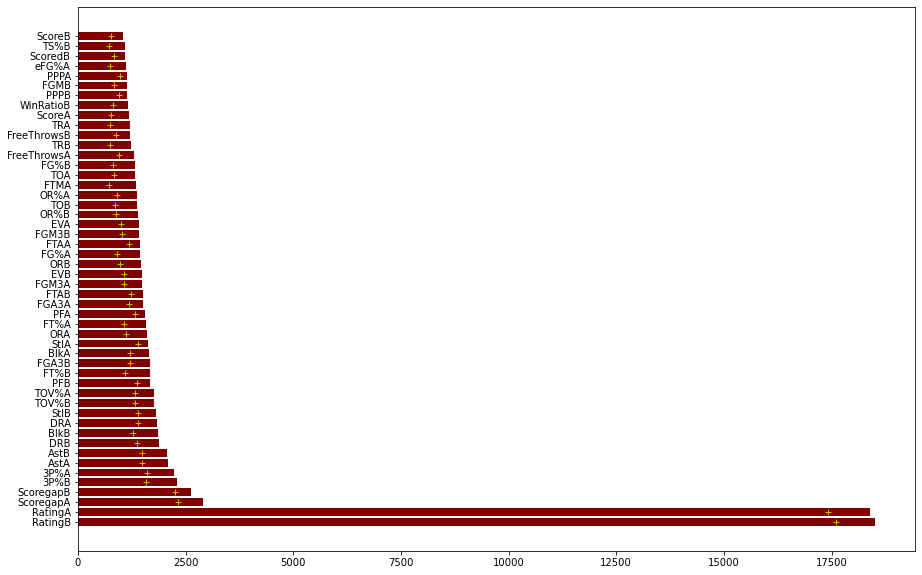

In [45]:

top = 50
fig = plt.figure(figsize = (15, 10))
# creating the bar plot
plt.barh(Best_valid.index[:top], Best_valid[:top], color ='maroon',)
plt.plot(Mean_valid[:top], Mean_valid.index[:top], 'y+')

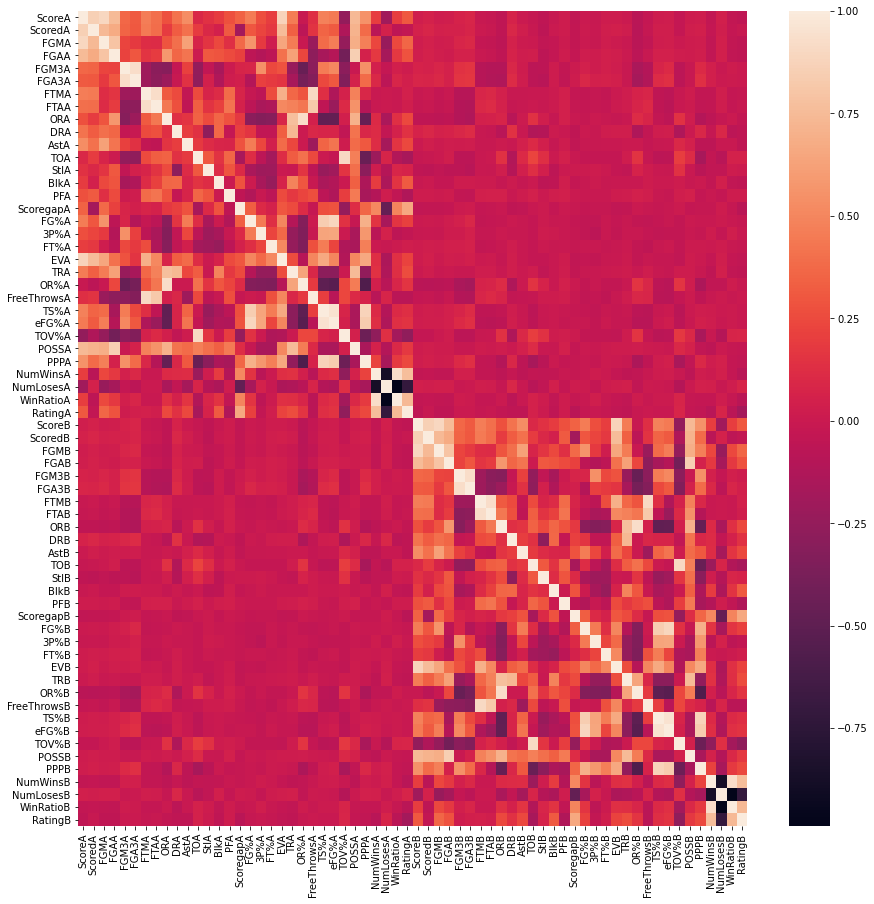

In [46]:
import seaborn as sns
plt.figure(figsize = (15,15))
corr = tourney_results[features].corr()
ax = sns.heatmap(corr) 

### V. Submission

In [47]:
test

,ID,Pred,Season,TeamIdA,TeamIdB,ScoreA,ScoredA,FGMA,FGAA,FGM3A,...,FreeThrowsB,TS%B,eFG%B,TOV%B,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB
0,2021_1101_1104,0.5,2021,1101,1104,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.202236,0.516253,0.480270,0.168501,85.805833,0.858527,24.0,6.0,0.800000,92.297375
1,2021_1101_1111,0.5,2021,1101,1111,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.233738,0.515352,0.472577,0.145042,76.587413,0.881209,13.0,11.0,0.541667,79.201104
2,2021_1101_1116,0.5,2021,1101,1116,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.221129,0.526317,0.486577,0.155470,87.953939,0.888981,22.0,6.0,0.785714,89.756430
3,2021_1101_1124,0.5,2021,1101,1124,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.152241,0.517712,0.496066,0.120352,83.467273,0.910809,22.0,2.0,0.916667,95.559039
4,2021_1101_1140,0.5,2021,1101,1140,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.190797,0.560098,0.527989,0.163867,79.680702,0.936633,19.0,6.0,0.760000,87.895307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2021_1452_1457,0.5,2021,1452,1457,77.305556,74.638889,26.388889,62.250000,7.444444,...,0.179135,0.466051,0.433579,0.120855,82.743478,0.819452,23.0,1.0,0.958333,83.170189
2274,2021_1452_1458,0.5,2021,1452,1458,77.305556,74.638889,26.388889,62.250000,7.444444,...,0.197951,0.526560,0.487662,0.116220,73.875000,0.930726,17.0,12.0,0.586207,86.688764
2275,2021_1455_1457,0.5,2021,1455,1457,68.071429,68.921429,22.964286,59.707143,7.671429,...,0.179135,0.466051,0.433579,0.120855,82.743478,0.819452,23.0,1.0,0.958333,83.170189
2276,2021_1455_1458,0.5,2021,1455,1458,68.071429,68.921429,22.964286,59.707143,7.671429,...,0.197951,0.526560,0.487662,0.116220,73.875000,0.930726,17.0,12.0,0.586207,86.688764


In [48]:
result = pd.read_csv("./2021NCAA.csv")
test["Predict"] = np.mean(y_test,axis=0)
pred = test[["TeamIdA","TeamIdB","Predict"]]

In [49]:
total = result.merge(pred,left_on=["TeamIdA","TeamIdB"],right_on=["TeamIdA","TeamIdB"])
total

,TeamIdA,TeamIdB,Result,Predict
0,1111,1313,0,0.641027
1,1179,1455,1,0.602010
2,1277,1417,0,0.252371
3,1140,1417,0,0.568993
4,1101,1417,0,0.294884
...,...,...,...,...
62,1160,1199,0,0.457196
63,1101,1400,1,0.180534
64,1163,1268,0,0.470990
65,1104,1233,1,0.894254


In [50]:
score = log_loss(total["Result"],total["Predict"])
score

0.5717113911108938